In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from PIL import Image, ImageDraw, ImageFont
from google.colab.patches import cv2_imshow

In [18]:
def read_image(img_path):
    img = Image.open(img_path)

    if img.mode == 'P':
        img = img.convert('RGB')

    return np.array(img)

In [3]:
def displayim(i1, i2, i3=None, t1="Original Image", t2="Equalised Image", t3=None):
    img1 = Image.fromarray(i1)
    img2 = Image.fromarray(i2)

    width1, height1 = img1.size
    width2, height2 = img2.size

    padding = 10
    title_space = 20

    total_width = width1 + width2 + 3*padding
    max_height = max(height1, height2) + title_space + padding

    if i3 is not None:
        img3 = Image.fromarray(i3)
        width3, height3 = img3.size
        total_width += width3 + 2*padding
        max_height = max(max_height, height3)

    new_img = Image.new('RGB', (total_width, max_height), color='white')

    new_img.paste(img1, (padding, title_space))
    new_img.paste(img2, (width1 + 2*padding, title_space))

    if i3 is not None:
        new_img.paste(img3, (width1 + width2 + 3*padding, title_space))

    draw = ImageDraw.Draw(new_img)

    try:
        font = ImageFont.truetype('arial.ttf', 15)
    except IOError:
        font = ImageFont.load_default()

    draw.text((width1 // 2, 10), t1, font=font, fill="black", anchor="mm")
    draw.text((width1 + padding + width2 // 2, 10), t2, font=font, fill="black", anchor="mm")

    if t3 is not None:
        draw.text((width1 + width2 + 2*padding + width3 // 2, 10), t3, font=font, fill="black", anchor="mm")

    aspect_ratio = total_width / max_height
    new_width = 1500
    new_height = int(new_width / aspect_ratio)

    new_img = new_img.resize((new_width, new_height))

    cv2_imshow(np.array(new_img)[..., ::-1])

In [4]:
def get_hist_table(image):
    if len(image.shape) == 2:
        unique_values, counts = np.unique(image.flatten(), return_counts=True)

        all_counts = [0] * 256

        for value, count in zip(unique_values, counts):
            all_counts[int(value)] = count

        all_counts = np.array(all_counts)
        prob = all_counts / np.sum(all_counts)
        cdf = np.cumsum(prob)

        df = pd.DataFrame({
            'Pixel Value': range(256),
            'Count': all_counts,
            'Probabilities': prob,
            'CDF': cdf
        })

    else:
        dfs = []

        channel_names = ['Red', 'Green', 'Blue']

        for channel in range(image.shape[2]):
            unique_values, counts = np.unique(image[:, :, channel].flatten(), return_counts=True)

            all_counts = [0] * 256

            for value, count in zip(unique_values, counts):
                all_counts[int(value)] = count

            all_counts = np.array(all_counts)
            prob = all_counts / np.sum(all_counts)
            cdf = np.cumsum(prob)

            channel_df = pd.DataFrame({
                'Pixel Value': range(256),
                'Count': all_counts,
                'Probabilities': prob,
                'CDF': cdf
            })
            channel_df.columns = [f'Pixel Value ({name})' for name in channel_names[channel:channel+1]] + \
                                 [f'Count ({name})' for name in channel_names[channel:channel+1]] + \
                                 [f'Probabilities ({name})' for name in channel_names[channel:channel+1]] + \
                                 [f'CDF ({name})' for name in channel_names[channel:channel+1]]

            dfs.append(channel_df)

        df = pd.concat(dfs, axis=1)

    return df

In [5]:
def plot_histogram(img):
    l = len(img.shape)

    if l == 2:
        pixels = img.flatten()
        plt.hist(pixels, bins=256, range=(0, 256))

    elif l == 3 and img.shape[2] == 3:
        bpixels = img[:, :, 2].flatten()
        gpixels = img[:, :, 1].flatten()
        rpixels = img[:, :, 0].flatten()

        plt.subplot(1, 3, 1)
        plt.hist(bpixels, bins=256, range=(0, 256), color='blue')
        plt.title("Histogram of Blue Channel")

        plt.subplot(1, 3, 2)
        plt.hist(gpixels, bins=256, range=(0, 256), color='green')
        plt.title("Histogram of Green Channel")

        plt.subplot(1, 3, 3)
        plt.hist(rpixels, bins=256, range=(0, 256), color='red')
        plt.title("Histogram of Red Channel")


    elif l == 3:
        num_channels = img.shape[2]
        plt.figure(figsize=(5 * num_channels, 5))

        for i in range(num_channels):
            pixels = img[:, :, i].flatten()
            plt.subplot(1, num_channels, i + 1)
            plt.hist(pixels, bins=256, range=(0, 256))
            plt.title(f"Histogram of Channel {i + 1}")

## Histogram Equalisation

In [29]:
def histeq(image):
    new_img = np.zeros_like(image)

    if len(image.shape) == 2:
        hist = get_hist_table(image)

        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                new_img[i, j] = hist['CDF'][image[i, j]] * 255

        return new_img.astype(np.uint8)

    elif len(image.shape) == 3:
        hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        v_channel = hsv_image[:, :, 2]

        hist = get_hist_table(v_channel)

        for i in range(v_channel.shape[0]):
            for j in range(v_channel.shape[1]):
                hsv_image[i, j, 2] = hist['CDF'][v_channel[i, j]] * 255

        equalized_hsv = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

        return equalized_hsv

### Grayscale Image Histogram Equalisation:

In [ ]:
path = input("Enter image path: ")

imgarr = read_image(path)

hist_df = get_hist_table(imgarr)

Enter image path: /content/lena_gray_dark.jpg


In [ ]:
hist_df.head()

Pixel Value  Count  Probabilities       CDF
0            0  81051       0.309185  0.309185
1            1   7992       0.030487  0.339672
2            2   9735       0.037136  0.376808
3            3   9031       0.034451  0.411259
4            4   9309       0.035511  0.446770

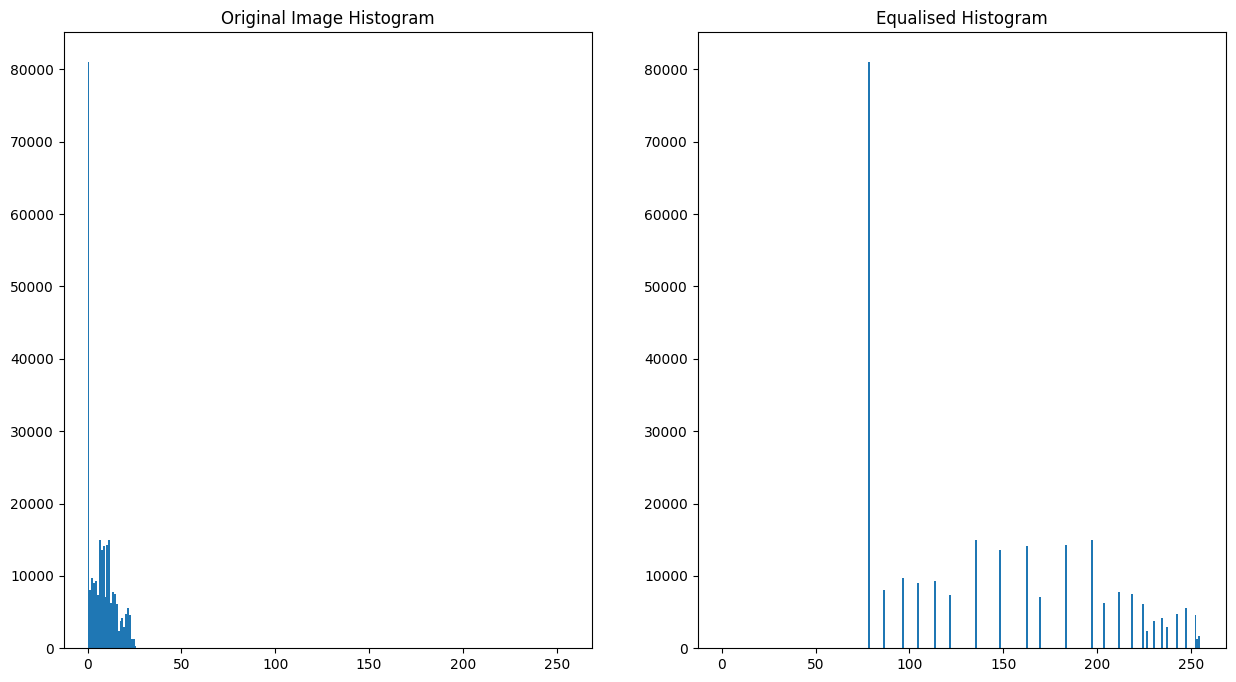

In [ ]:
cont = histeq(imgarr)

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plot_histogram(imgarr)
plt.title('Original Image Histogram')

plt.subplot(1, 2, 2)
plot_histogram(cont)
plt.title('Equalised Histogram')

plt.show()

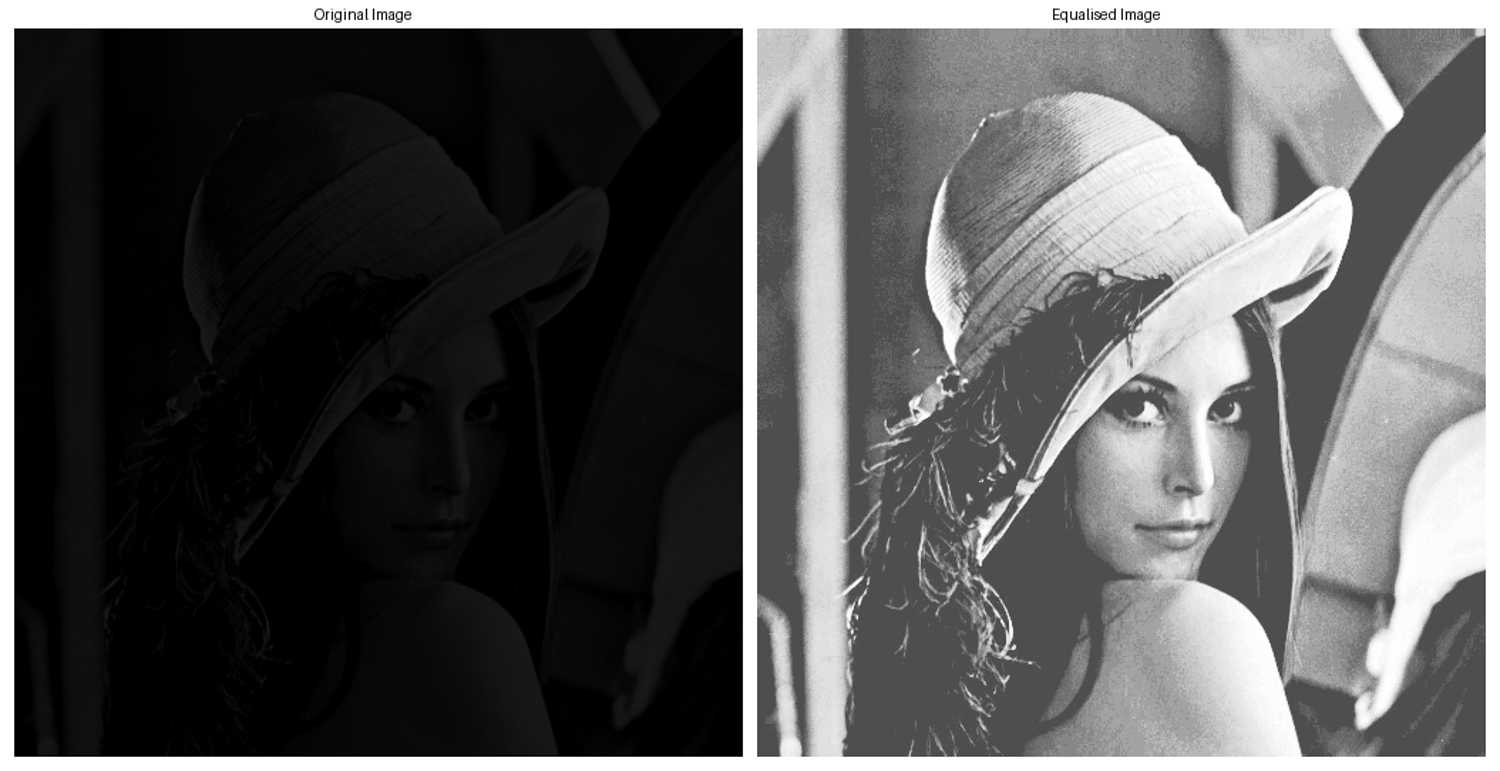

In [ ]:
displayim(imgarr, cont)

### Colour Image Equalisation:

In [30]:
path = input("Enter image path: ")

imgarr = read_image(path)

hist_df = get_hist_table(imgarr)

hist_df.head()

Enter image path: /content/livingroom_dark.tiff


Pixel Value (Red)  Count (Red)  Probabilities (Red)  CDF (Red)  \
0                  0            0             0.000000   0.000000   
1                  1         3563             0.054367   0.054367   
2                  2         1565             0.023880   0.078247   
3                  3         2185             0.033340   0.111588   
4                  4         2825             0.043106   0.154694   

   Pixel Value (Green)  Count (Green)  Probabilities (Green)  CDF (Green)  \
0                    0              0               0.000000     0.000000   
1                    1           6378               0.097321     0.097321   
2                    2           1715               0.026169     0.123489   
3                    3           1791               0.027328     0.150818   
4                    4           1777               0.027115     0.177933   

   Pixel Value (Blue)  Count (Blue)  Probabilities (Blue)  CDF (Blue)  
0                   0             0              0.000000    0.000000  
1                   1          2957              0.045120    0.045120  
2                   2          3169              0.048355    0.093475  
3                   3          2090              0.031891    0.125366  
4                   4          1804              0.027527    0.152893

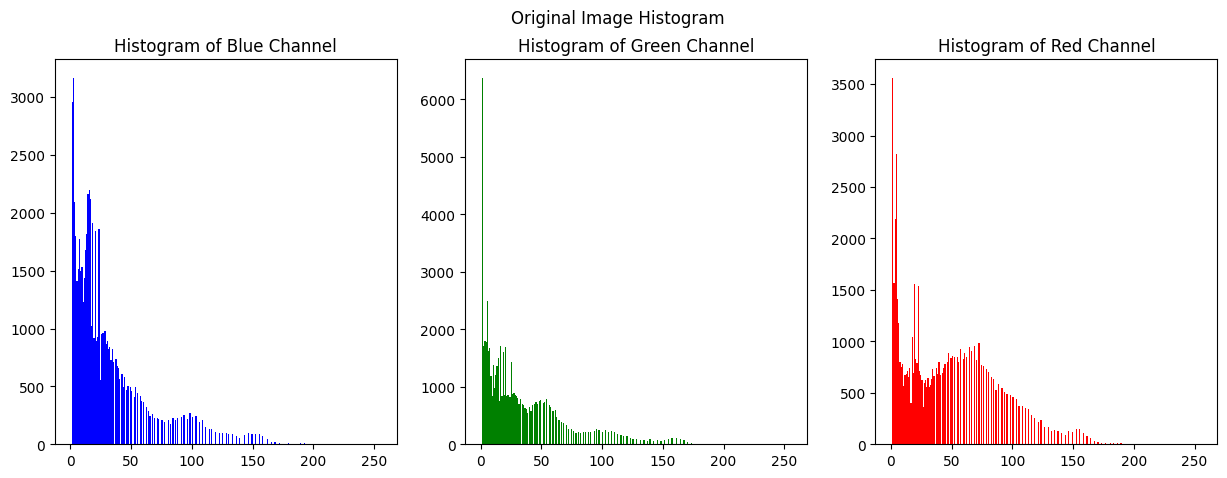

------------------------------------------------------------------------------------------------------------------------------------


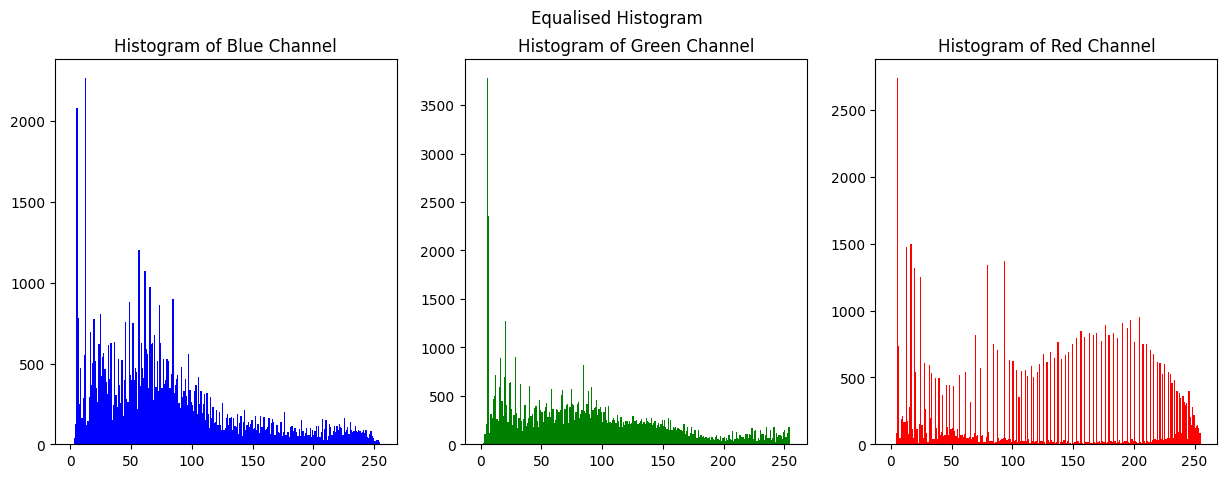

In [31]:
cont = histeq(imgarr)

plt.figure(figsize=(15, 5))
plt.suptitle('Original Image Histogram')

plot_histogram(imgarr)
plt.show()

print("------------------------------------------------------------------------------------------------------------------------------------")

plt.figure(figsize=(15, 5))
plt.suptitle('Equalised Histogram')
plot_histogram(cont)

plt.show()

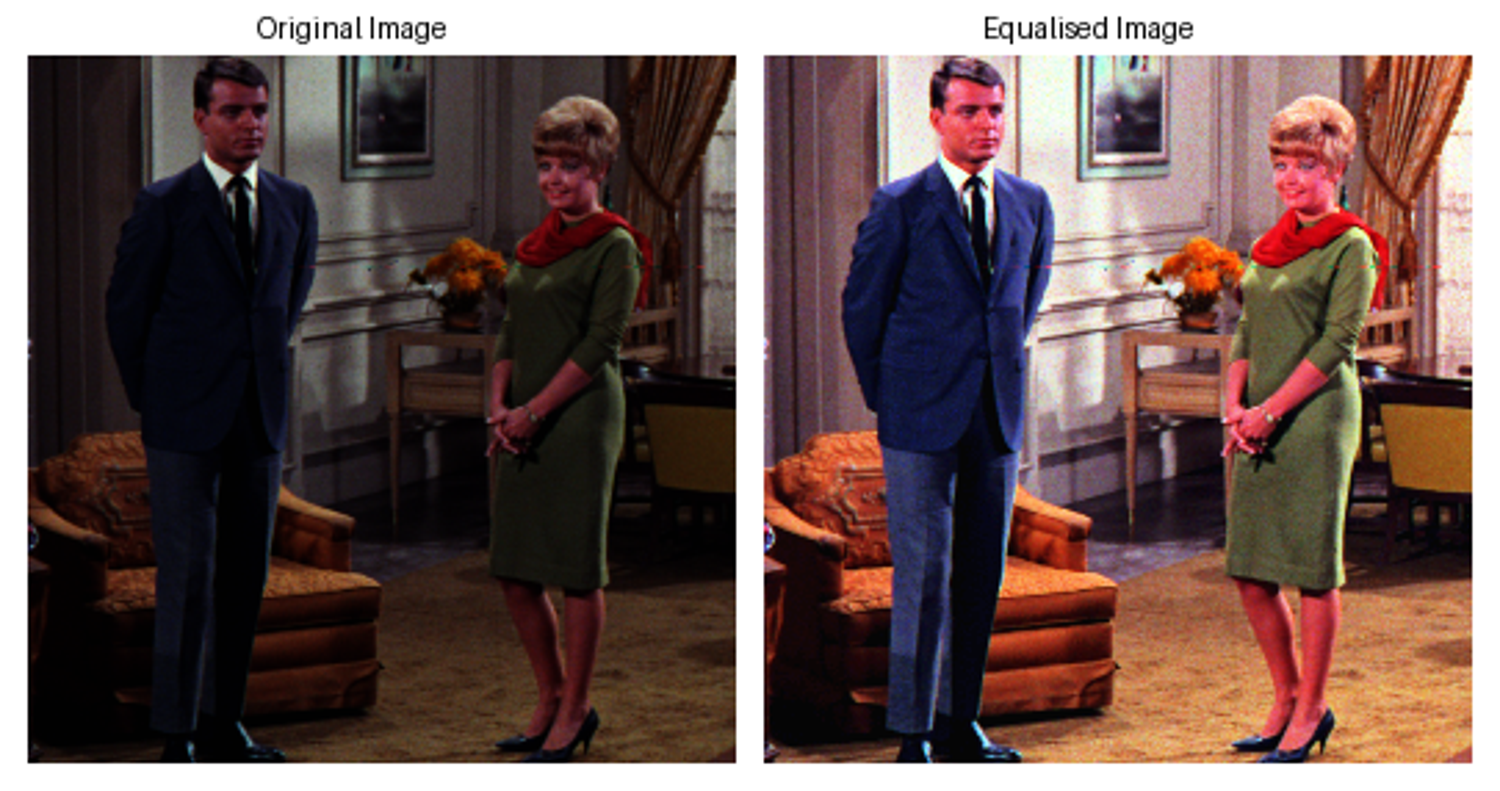

In [32]:
displayim(imgarr, cont)

## Histogram Matching

Matching on RGB Channels separately

In [64]:
def histogram_matching(source_image, target_image):
    source_df = get_hist_table(source_image)
    target_df = get_hist_table(target_image)

    if len(source_image.shape) == 2:
        source_cdf = source_df['CDF'].values
        target_cdf = target_df['CDF'].values

        mapping = np.zeros(256, dtype=np.uint8)

        source_idx = 0
        for target_idx in range(256):
            while (source_idx < 255) and (target_cdf[target_idx] > source_cdf[source_idx]):
                source_idx += 1
            mapping[target_idx] = source_idx

        matched_image = mapping[target_image]

    else:
        matched_image = np.zeros_like(target_image)
        channel_names = ['Red', 'Green', 'Blue']

        for channel in range(source_image.shape[2]):
            source_cdf = source_df[f'CDF ({channel_names[channel]})'].values
            target_cdf = target_df[f'CDF ({channel_names[channel]})'].values

            mapping = np.zeros(256, dtype=np.uint8)

            source_idx = 0
            for target_idx in range(256):
                while (target_idx < 255) and (target_cdf[target_idx] > source_cdf[source_idx]):
                    source_idx += 1
                mapping[target_idx] = source_idx

            matched_image[:, :, channel] = mapping[target_image[:, :, channel]]

    return matched_image.astype(np.uint8)

### Histogram Matching for Grayscale Images:

In [ ]:
source_path = input("Enter source image path: ")
target_path = input("Enter target image path: ")

source_img = read_image(source_path)
target_img = read_image(target_path)

new_img = histogram_matching(source_img, target_img)

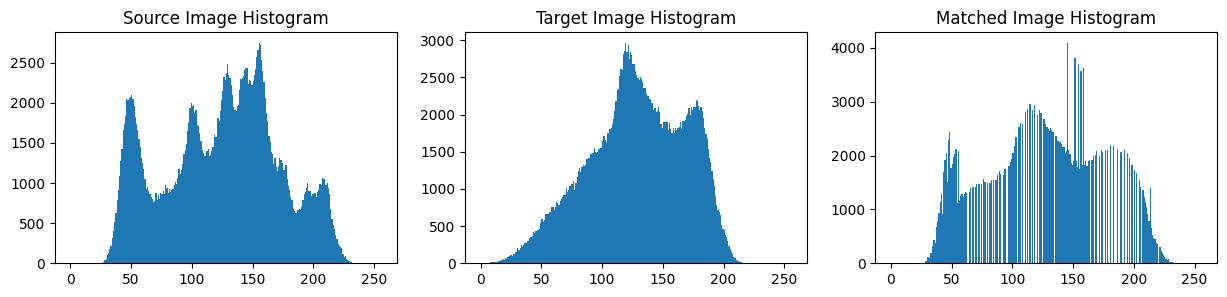

In [ ]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plot_histogram(source_img)
plt.title('Source Image Histogram')

plt.subplot(1, 3, 2)
plot_histogram(target_img)
plt.title('Target Image Histogram')

plt.subplot(1, 3, 3)
plot_histogram(new_img)
plt.title('Matched Image Histogram')

plt.show()

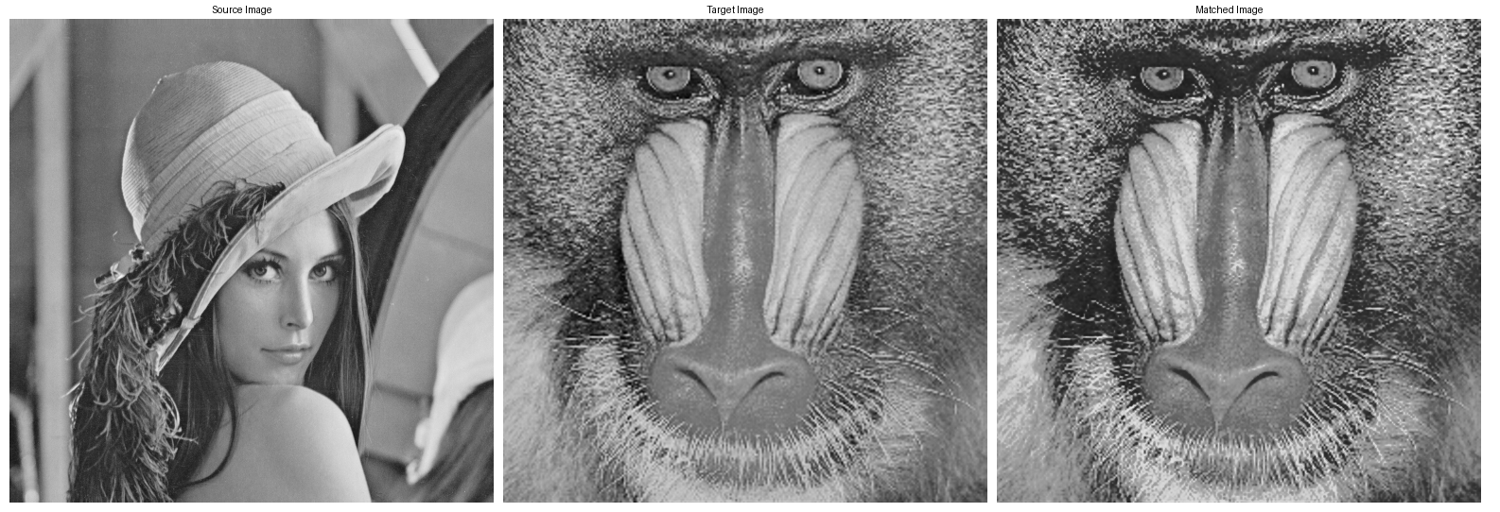

In [ ]:
displayim(source_img, target_img, new_img, 'Source Image', 'Target Image', 'Matched Image')

### Histogram Matching for Coloured Images

In [56]:
source_path = input("Enter source image path: ")
target_path = input("Enter target image path: ")

source_img = read_image(source_path)
target_img = read_image(target_path)

Enter source image path: /content/lena_color_512.jpg
Enter target image path: /content/mandril_color.jpg


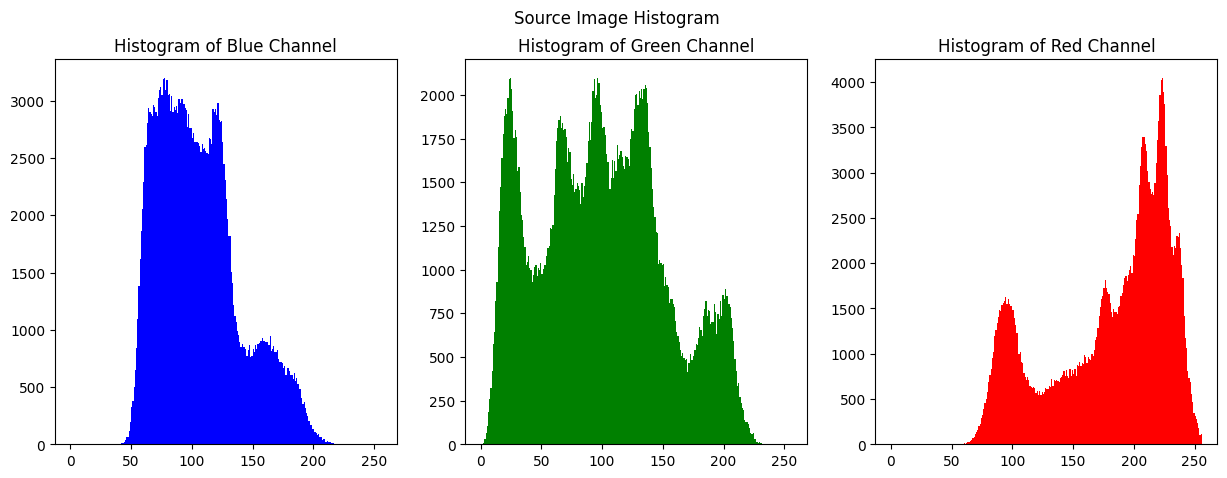

------------------------------------------------------------------------------------------------------------------------------------


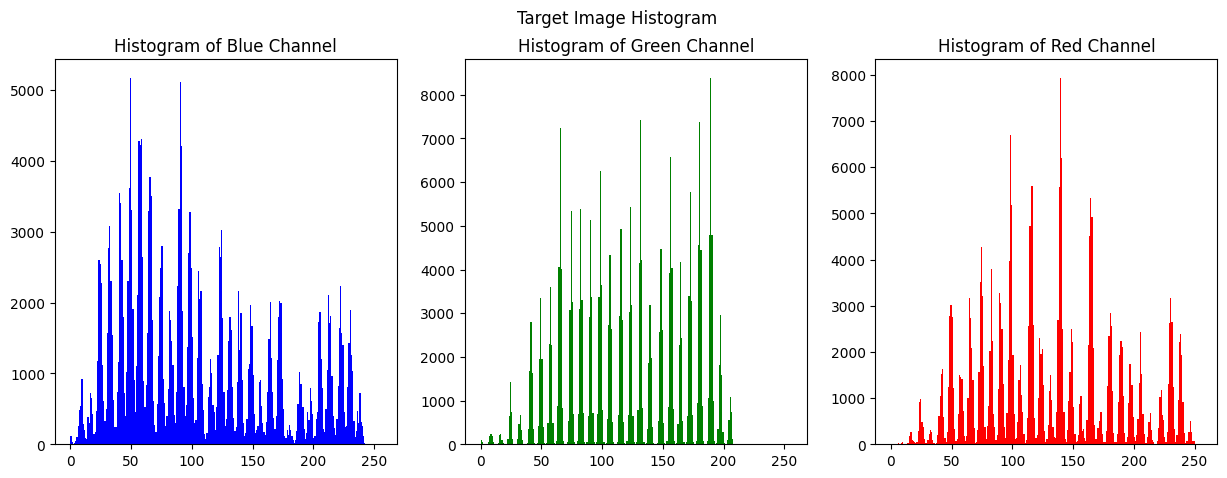

------------------------------------------------------------------------------------------------------------------------------------


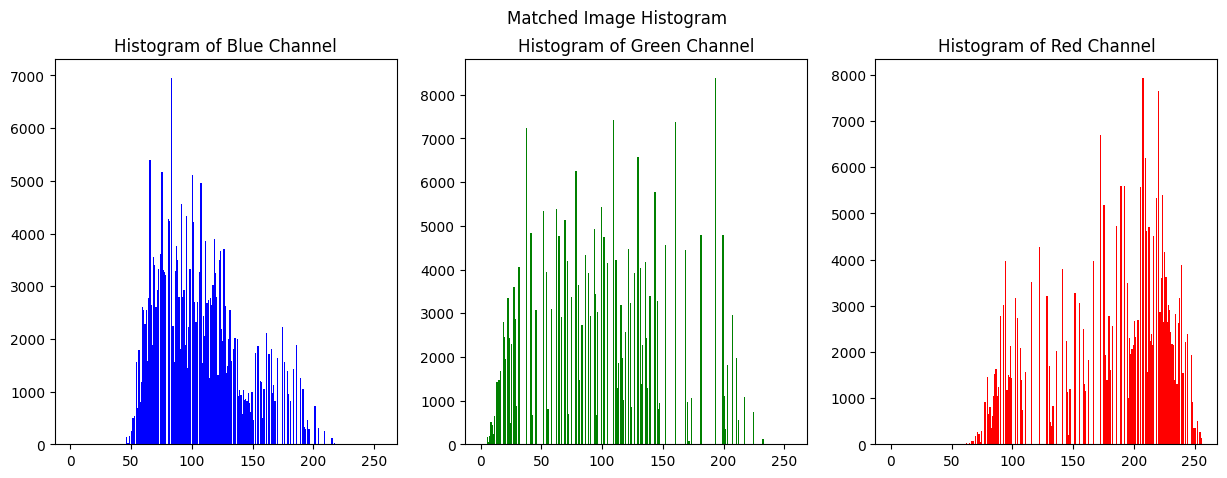

In [65]:
new_img = histogram_matching(source_img, target_img)

plt.figure(figsize=(15, 5))
plt.suptitle('Source Image Histogram')
plot_histogram(source_img)
plt.show()

print("------------------------------------------------------------------------------------------------------------------------------------")

plt.figure(figsize=(15, 5))
plt.suptitle('Target Image Histogram')
plot_histogram(target_img)
plt.show()

print("------------------------------------------------------------------------------------------------------------------------------------")

plt.figure(figsize=(15, 5))
plt.suptitle('Matched Image Histogram')
plot_histogram(new_img)
plt.show()

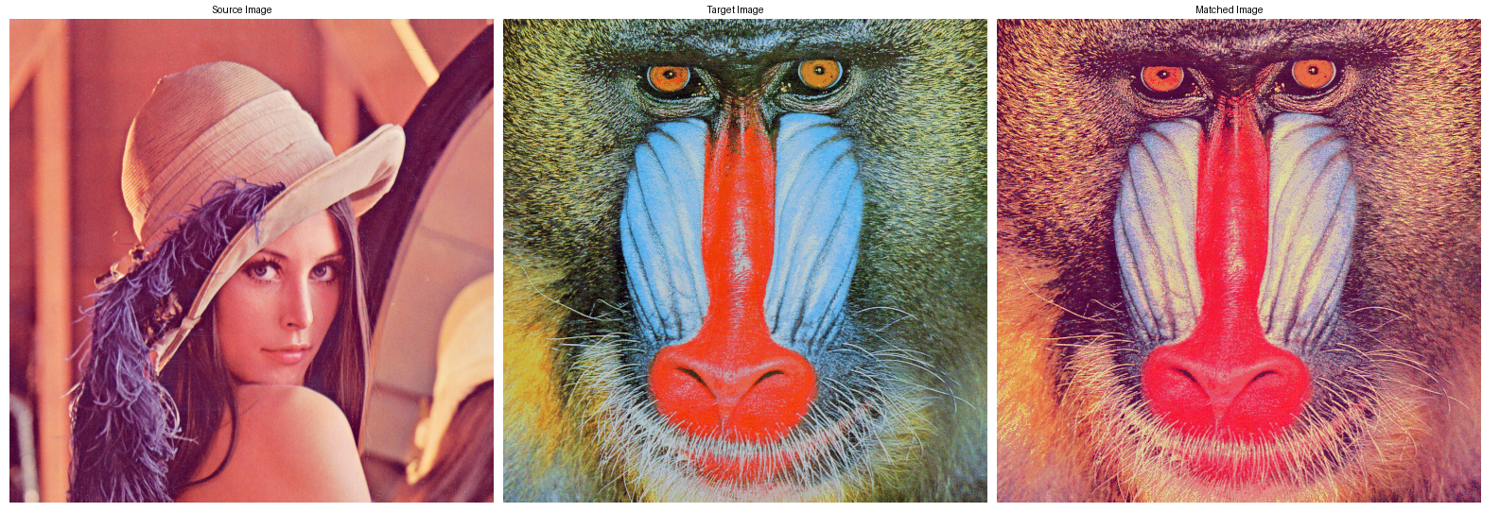

In [66]:
displayim(source_img, target_img, new_img, 'Source Image', 'Target Image', 'Matched Image')

Histogram Matching for coloured spaces using HSV

In [59]:
def histogram_matching_hsv(source_image, target_image):
    source_hsv = cv2.cvtColor(source_image, cv2.COLOR_RGB2HSV)
    target_hsv = cv2.cvtColor(target_image, cv2.COLOR_RGB2HSV)

    source_v = source_hsv[:, :, 2]
    target_v = target_hsv[:, :, 2]

    source_df = get_hist_table(source_v)
    target_df = get_hist_table(target_v)

    source_cdf = source_df['CDF'].values
    target_cdf = target_df['CDF'].values

    mapping = np.zeros(256, dtype=np.uint8)

    source_idx = 0
    for target_idx in range(256):
        while (source_idx < 255) and (target_cdf[target_idx] > source_cdf[source_idx]):
            source_idx += 1
        mapping[target_idx] = source_idx

    target_hsv[:, :, 2] = mapping[target_v]

    matched_image = cv2.cvtColor(target_hsv, cv2.COLOR_HSV2RGB)

    return matched_image.astype(np.uint8)

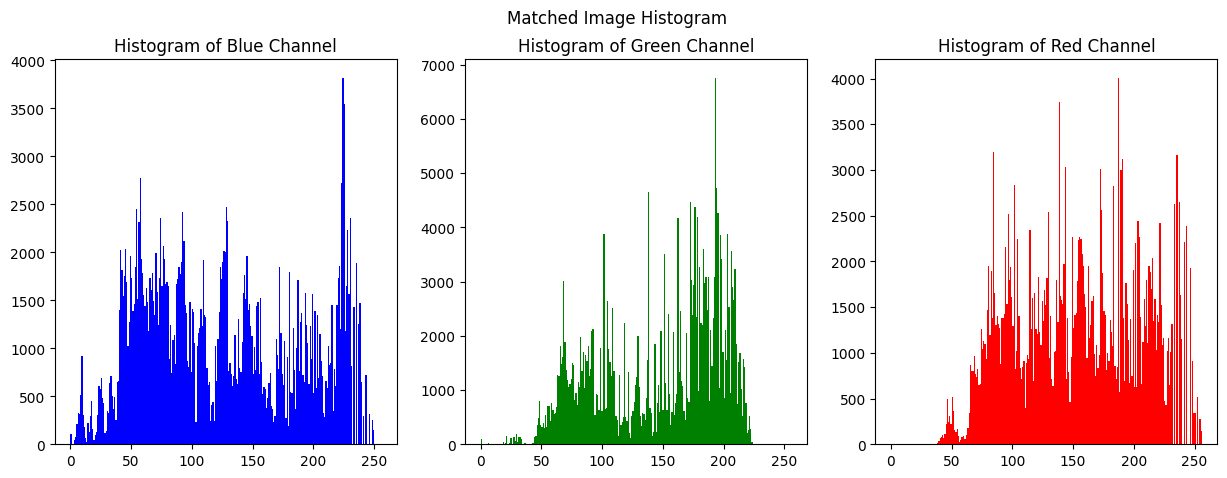

In [60]:
new_img = histogram_matching_hsv(source_img, target_img)

plt.figure(figsize=(15, 5))
plt.suptitle('Matched Image Histogram')
plot_histogram(new_img)
plt.show()

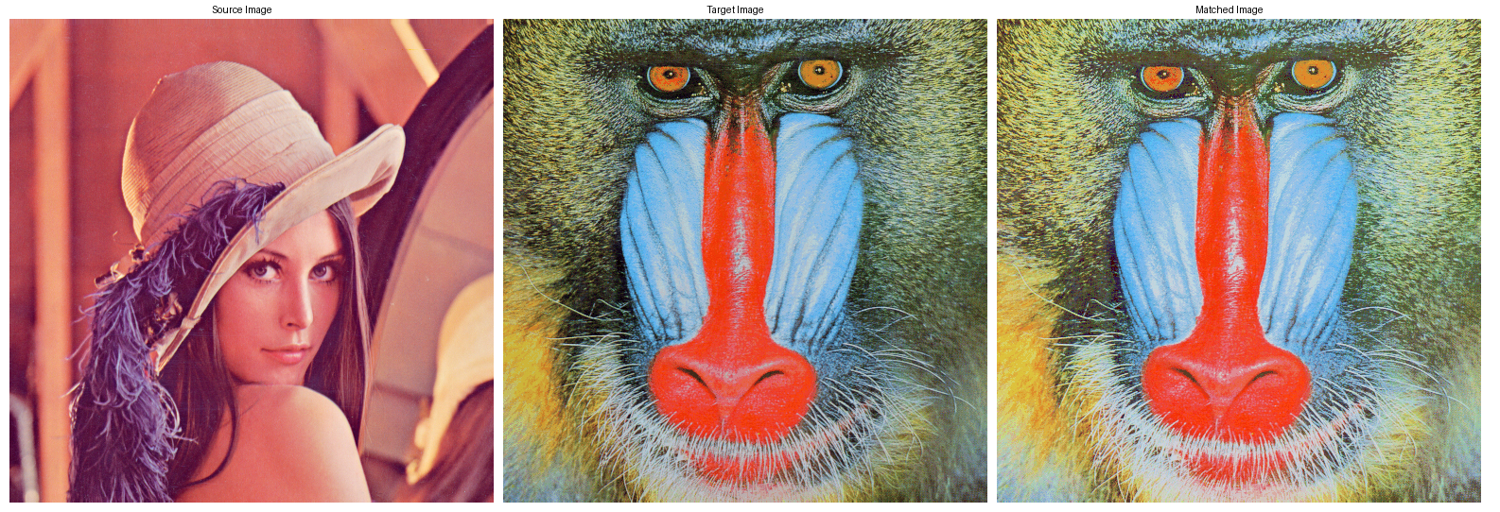

In [61]:
displayim(source_img, target_img, new_img, 'Source Image', 'Target Image', 'Matched Image')